<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#network-generation" data-toc-modified-id="network-generation-1">network generation</a></span></li><li><span><a href="#modularity-and-vaccination" data-toc-modified-id="modularity-and-vaccination-2">modularity and vaccination</a></span><ul class="toc-item"><li><span><a href="#plot-results" data-toc-modified-id="plot-results-2.1">plot results</a></span></li></ul></li><li><span><a href="#network-figure" data-toc-modified-id="network-figure-3">network figure</a></span></li><li><span><a href="#segregation-effect" data-toc-modified-id="segregation-effect-4">segregation effect</a></span><ul class="toc-item"><li><span><a href="#run-simulations" data-toc-modified-id="run-simulations-4.1">run simulations</a></span></li><li><span><a href="#plot-network-metrics" data-toc-modified-id="plot-network-metrics-4.2">plot network metrics</a></span></li><li><span><a href="#vaccination-dependency-of-segregation-effect" data-toc-modified-id="vaccination-dependency-of-segregation-effect-4.3">vaccination-dependency of segregation effect</a></span></li></ul></li></ul></div>

<center>
    <big>
        <b>
            SIMULATION NOTEBOOK
        </b>
    </big>

</center>

<center>
        here we simulate (measles) outbreaks after generating social networks with _social segregation_
</center>

In [1]:
# basic modules
import pandas as pd
import numpy as np
import gc
import random
import timeit

# packages to plot
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
%matplotlib inline

# module for network analysis
import networkx as nx

In [2]:
import multiprocessing

# this line was introduced after upgrading to python 3.8 
# >> thanks to Darkonaut < https://stackoverflow.com/questions/60518386/error-with-module-multiprocessing-under-python3-8
multiprocessing.set_start_method("fork")

# network generation

for the time-being we choose a small-word network with rewiring probability __p=0.1__ - see next subsection

In [7]:
def generate_netw_fun(my_n=10**3, my_k=10, my_p=0.1, my_net_type='WS'):
    '''
    generate Watts-Strogatz/erdos_renyi network, 
    with uniform distribution of attribute ('social status') in [0,1]
    * my_net_type= 'WS' or 'ER'
    * my_k: number of neighbours for WS graph
    * my_p: probability of (re)wiring used for both my_net_type
    '''

    if my_net_type == 'WS':
        net_to_return = nx.watts_strogatz_graph(my_n, my_k, my_p)
    elif my_net_type == 'ER':
        net_to_return = nx.erdos_renyi_graph(my_n, my_p)
    else:
        raise ValueError('WRONG NETWORK TYPE -- must be WS or er')

    for my_node in net_to_return.nodes():

        net_to_return.nodes[my_node]['social_status'] = np.random.random()

    return net_to_return

In [4]:
# test network generative fun
%time init_net = generate_netw_fun(my_p=0.01,my_net_type='WS')

CPU times: user 10 ms, sys: 1.26 ms, total: 11.3 ms
Wall time: 11 ms


initial metrics: basic measures / deg. dist. / average shortest path / clustering coeff.

n_nodes 1000 n_edges 5000 n_self_loops 0 is_connected True
average_clustering 0.6476305916305876
CPU times: user 28.2 ms, sys: 1.7 ms, total: 29.9 ms
Wall time: 28.7 ms


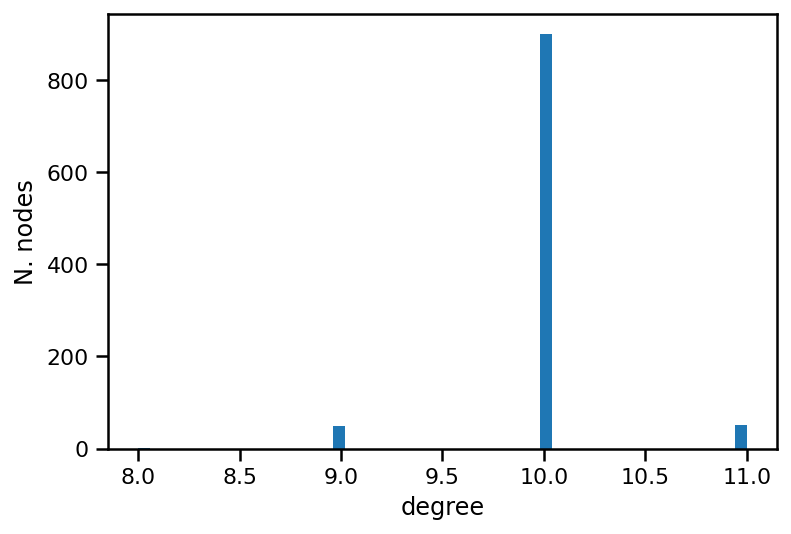

In [5]:
print('n_nodes', init_net.number_of_nodes(), 
      'n_edges', init_net.number_of_edges(),
      'n_self_loops', nx.number_of_selfloops(init_net), 
      'is_connected', nx.is_connected(init_net))

# %time print('average_shortest_path_length',nx.average_shortest_path_length(init_net))
%time print('average_clustering',nx.average_clustering(init_net))

plt.hist(dict(init_net.degree()).values(), bins=50)
plt.ylabel("N. nodes")
plt.xlabel("degree");

1 - measure initial _social status assortativity_  - at the beginning is basically 0, as expected

(2 - _check_ that it's indeed a uniform dist)

mind that `attribute_assortativity_coefficient` is not doing what we need - check [this SO post](https://stats.stackexchange.com/questions/401490/graph-theory-network-homophily-with-continuous-node-attribute) -

so, we build our assortativity fun:

In [8]:
def att_assortativity(nx_graph,attribute='social_status'):
    
    '''
    return corr. coeff. between node\'s and 
    node\'s n.n. average 'attribute', 
    for a given networkX graph 
    '''
    ss_mix_dict = nx.attribute_mixing_dict(nx_graph,attribute)
    aver_neigh_ss = [np.mean(list(ss_mix_dict[val].keys())) for val in ss_mix_dict.keys()]
    return np.corrcoef(list(ss_mix_dict.keys()),aver_neigh_ss)[0,1]

attribute assortativity: 0.003129743603432079
degree_pearson_correlation_coefficient: 0.006697915343554748


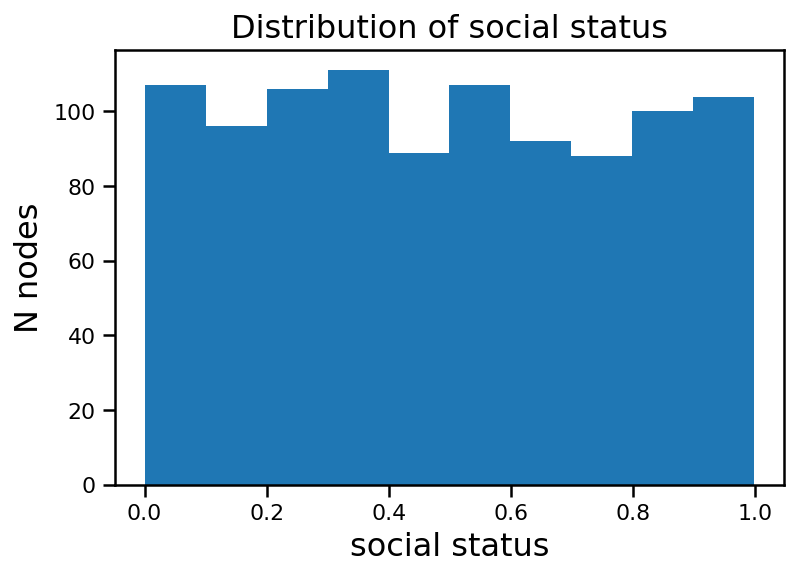

In [7]:
plt.title('Distribution of social status',size=16)
plt.hist(nx.get_node_attributes(init_net,'social_status').values())
plt.ylabel('N nodes',size=16);
plt.xlabel('social status',size=16);

print('attribute assortativity:',att_assortativity(init_net))

print('degree_pearson_correlation_coefficient:',nx.degree_pearson_correlation_coefficient(init_net))

define a _''cyclic'' metric_ - to avoid boundary effect

In [9]:
def circ_dist(a, b):

    return min(abs(a - b), 1 - abs(a - b))

...and the normal one to compare 

In [9]:
def eucl_dist(a, b):

    return abs(a - b)

show distance distribution – double check

In [10]:
from itertools import combinations

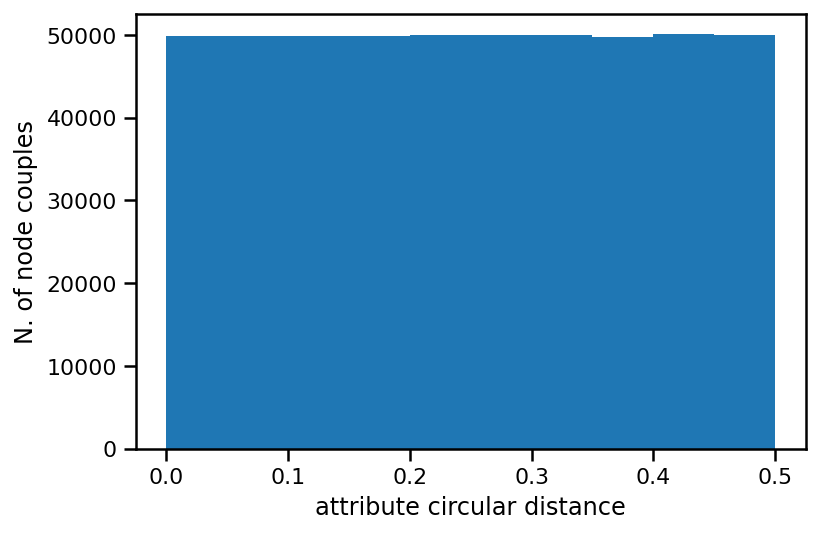

In [11]:
dist_list = [
    circ_dist(init_net.nodes[my_c[0]]['social_status'],
              init_net.nodes[my_c[1]]['social_status'])
    for my_c in combinations(init_net.nodes(), 2)
]

plt.hist(dist_list)
plt.xlabel('attribute circular distance')
plt.ylabel('N. of node couples')
plt.show();

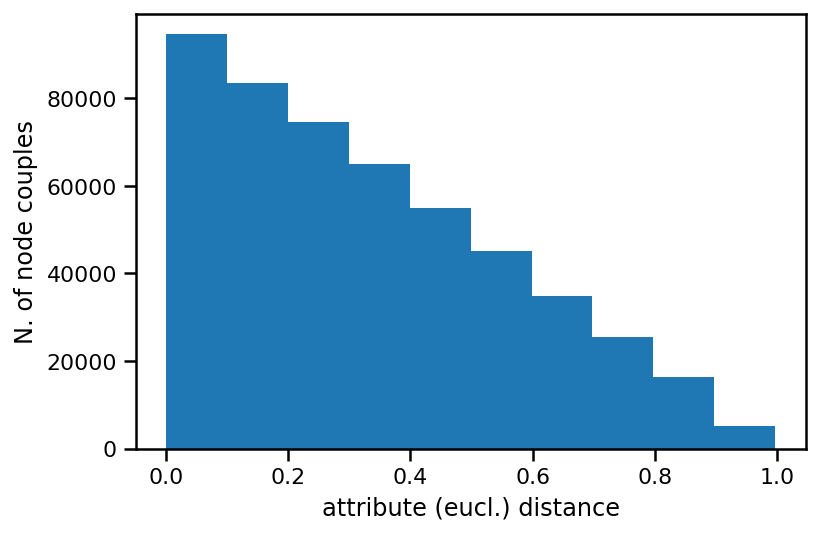

In [12]:
dist_list = [
    eucl_dist(init_net.nodes[my_c[0]]['social_status'],
              init_net.nodes[my_c[1]]['social_status'])
    for my_c in combinations(init_net.nodes(), 2)
]

plt.hist(dist_list)
plt.xlabel('attribute (eucl.) distance')
plt.ylabel('N. of node couples')
plt.show()

# modularity and vaccination

In [17]:
def vacc_fun(graph_to_vacc, coverage=0.8):
    '''
    * make a copy of the graph 
    * runs random vaccination (nodes removal) with given a coverage in [0,1]
    * return vaccinated graph
    '''

    graph_copy = graph_to_vacc.copy()
    to_be_removed = random.sample(graph_copy.nodes(),
                                  int(graph_copy.number_of_nodes() * coverage))
    [graph_copy.remove_node(node) for node in to_be_removed]

    return graph_copy

In [11]:
def modul_vacc_fun(prob):
    '''
    returns metrics on network after vaccination
    * prob: probability parameter for WS graph model
    '''

    # def list to store results
    net_prop = []

    ## generate graph
    g = nx.watts_strogatz_graph(n_nodes, nnn, prob)

    ##  check if graph is connected ## ##
    if not nx.is_connected(g):
        raise ValueError('graph not connected')

    else:

        # compute communities and modularity
        my_comm = nx.community.greedy_modularity_communities(g)
        N_comm = len(my_comm)
        modul = nx.community.modularity(g, my_comm)

        for n in range(n_vacc_runs):

            ## run vaccination
            vacc_graph = vacc_fun(g, coverage=vacc_cov)

            ## connected components
            n_cc_vacc = nx.number_connected_components(vacc_graph)
            nodes_gcc_vacc = max(nx.connected_components(vacc_graph), key=len)
            gcc_vacc = vacc_graph.subgraph(nodes_gcc_vacc)
            gcc_vacc_fract = gcc_vacc.number_of_nodes(
            ) / vacc_graph.number_of_nodes()

            ## communities and modularity
            my_comm = nx.community.greedy_modularity_communities(gcc_vacc)
            N_comm_gcc_vacc = len(my_comm)
            modul_gcc_vacc = nx.community.modularity(gcc_vacc, my_comm)

            ## estimation of upper bound of epidemics size
            cc_sizes = [len(cc) for cc in nx.connected_components(vacc_graph)]
            esti_uppb_epi = sum(np.array(cc_sizes)**
                                2) / vacc_graph.number_of_nodes()

            ## store all metrics
            net_prop.append({
                'N_comm': N_comm,
                'modul': modul,
                'n_cc_vacc': n_cc_vacc,
                'gcc_vacc_fract': gcc_vacc_fract,
                'N_comm_gcc_vacc': N_comm_gcc_vacc,
                'modul_gcc_vacc': modul_gcc_vacc,
                'esti_uppb_epi': esti_uppb_epi,
                'log_10_rew_prob': np.log10(prob)
            })

    print('done with rew. prob. :', prob)
    return net_prop

here we parallelize over rewiring prob

In [18]:
## set graph properties
nnn = 10  # N. nearest neighbours
n_nodes = 1000

## parameters for vaccination
n_vacc_runs = 10
vacc_cov = 0.9

prob_array = np.logspace(-3, -0.1, num=16)

In [31]:
pool = multiprocessing.Pool(multiprocessing.cpu_count())

netw_prop = pool.map(modul_vacc_fun, prob_array)

pool.close()
pool.join()

done with rew. prob. : 0.0015607499630921114
done with rew. prob. : done with rew. prob. : 0.0059338058627532810.02255970068843576

done with rew. prob. :done with rew. prob. :  0.001
0.009261187281287938
done with rew. prob. : 0.014454397707459272
done with rew. prob. : 0.002435940447292027
done with rew. prob. : 0.0038018939632056127
done with rew. prob. : 0.03521005201684519
done with rew. prob. : 0.054954087385762455
done with rew. prob. : 0.08576958985908942
done with rew. prob. : 0.13386488420699927
done with rew. prob. : 0.20892961308540386
done with rew. prob. : 0.3260868859118932
done with rew. prob. : 0.7943282347242815
done with rew. prob. : 0.5089400951518088


## plot results

make results plottable ...

In [32]:
# first need to flatten the list
netw_prop = [i for item in netw_prop for i in item]

summary_df = pd.DataFrame(netw_prop)

print(summary_df.shape)
summary_df.head()

(160, 8)


,N_comm,modul,n_cc_vacc,gcc_vacc_fract,N_comm_gcc_vacc,modul_gcc_vacc,esti_uppb_epi,log_10_rew_prob
0,3,0.630194,60,0.05,2,0.220000,2.14,-3.0
1,3,0.630194,60,0.04,2,0.166667,2.06,-3.0
2,3,0.630194,61,0.04,2,0.166667,2.10,-3.0
3,3,0.630194,56,0.05,2,0.030612,2.42,-3.0
4,3,0.630194,59,0.06,2,0.075000,2.34,-3.0


In [33]:
## melt df to facilitate plot with sns
melted_df = summary_df.melt(id_vars='log_10_rew_prob')

# save results
f_name = f'mod_effect_on_vacc_n_nodes_{n_nodes}_nnn_{nnn}_vacc_cov_{vacc_cov}_n_vacc_runs_{n_vacc_runs}'
melted_df.to_csv('sim_plots/modul_vacc_WS/' + f_name + '.csv')

print(melted_df.shape)
melted_df.head()

(1120, 3)


,log_10_rew_prob,variable,value
0,-3.0,N_comm,3.0
1,-3.0,N_comm,3.0
2,-3.0,N_comm,3.0
3,-3.0,N_comm,3.0
4,-3.0,N_comm,3.0


 ... and visualize them 

In [34]:
my_p = sns.catplot(data=melted_df,x='log_10_rew_prob',y='value',col='variable',
#                    col_order=new_order,
                   col_wrap=4,sharex=True,sharey=False,color='C0',s=3)

my_p.set_titles(size=16)
my_p.set_ylabels('')
my_p.set_xticklabels([np.round(t,2) for t in melted_df.log_10_rew_prob.unique()],rotation=40)
plt.tight_layout()

plt.savefig('sim_plots/modul_vacc_WS/' + f_name + '.pdf')

merge results for different vaccination coverages

In [ ]:
import glob

all_cov_WS_F = pd.DataFrame()

for my_f in glob.glob('./sim_plots/modul_vacc_WS/*.csv'):

    temp_df = pd.read_csv(my_f)
    temp_df = temp_df[temp_df.variable == 'esti_uppb_epi']

    # add columns with vacc. cov.
    temp_df['vacc_cov'] = np.float(my_f.split('_')[14])

    all_cov_WS_F = pd.concat([all_cov_WS_F, temp_df])

# remove useless col
all_cov_WS_F = all_cov_WS_F.iloc[:, 1:]

# drop the name of the metric as col, and rename the columns with its value
all_cov_WS_F.drop('variable', axis=1, inplace=True)
all_cov_WS_F.rename(columns={'value': 'esti_uppb_epi'}, inplace=True)

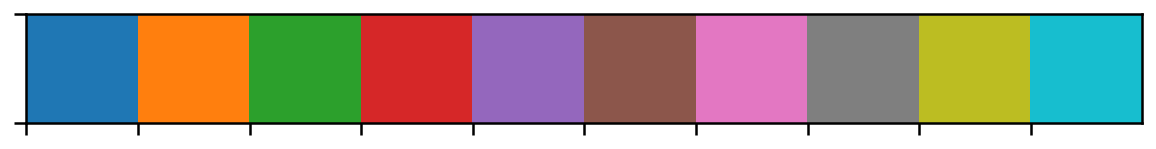

In [38]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [39]:
ws_F_plot = sns.stripplot(data=all_cov_WS_F,
                          x='log_10_rew_prob',
                          y='esti_uppb_epi',
                          hue='vacc_cov',
                          alpha=0.5)

### ### ### add h-lines for theor. max for fully connected graph ### ###
left_N_fun = lambda x: n_nodes * (1 - x)
i = 0
for vacc in sorted(all_cov_WS_F.vacc_cov.unique()):
    ws_F_plot.axhline(left_N_fun(vacc),
                      color=current_palette[i],
                      alpha=0.5,
                      linestyle='dashed')
    i += 1
### ### ### ### ### ### ### ### ### ### ### ### ### ### ###

ws_F_plot.set_xticklabels(
    [np.round(t, 2) for t in all_cov_WS_F.log_10_rew_prob.unique()],
    rotation=40)

ws_F_plot.legend(title='vaccination\ncoverage', bbox_to_anchor=(1, 1))

ws_F_plot.set_ylim([10**0, 10**3])
ws_F_plot.set_yscale('log')
ws_F_plot.set_xlabel('log10 rewiring probability')
ws_F_plot.set_ylabel('average outbreak size\n' + r'upper bound ($\bar{F}$)')

plt.tight_layout()

ws_F_plot_name = f'WS_F_VS_vacc_n_nodes_{n_nodes}_nnn_{nnn}_n_vacc_runs_{n_vacc_runs}'
plt.savefig('sim_plots/modul_vacc_WS/' + ws_F_plot_name + '.pdf')

# network figure

In [16]:
## set graph properties
nnn = 10  # N. nearest neighbours -- for WS only
n_nodes = 500
p_edge = 0.8

## parameters for vaccination
vacc_cov = 0.8

graph_name = f'full_n_nodes_{n_nodes}_nnn_{nnn}_p_edge_{p_edge}'

in case you want to generate a new graph (frozen cell)

In [6]:
# generate graphs
original_ws = nx.watts_strogatz_graph(n_nodes,nnn,p_edge)
vacc_graph = vacc_fun(original_ws,vacc_cov) # vacc_fun is def. in the next section

print('original_ws:',original_ws.number_of_nodes(),original_ws.number_of_edges())
print('vacc_graph:',vacc_graph.number_of_nodes(),vacc_graph.number_of_edges())

# save graph
nx.readwrite.edgelist.write_edgelist(original_ws,path='network_fig/' + graph_name)

original_ws: 500 2500
vacc_graph: 100 113


in order to re-use the same graph 

In [17]:
# read back graph
original_ws = nx.readwrite.edgelist.read_edgelist('network_fig/' + graph_name)
# build again the vacc graph
vacc_graph = vacc_fun(original_ws,vacc_cov)

In [ ]:
my_pos_x = np.random.random(original_ws.number_of_nodes()) * 0.5
my_pos_y = np.random.random(original_ws.number_of_nodes()) * 0.5

pos_dict = {}
for my_n, i in zip(original_ws.nodes(), range(original_ws.number_of_nodes())):

    pos_dict[my_n] = [my_pos_x[i], my_pos_y[i]]

In [ ]:
shifted_pos = {
    k: [pos_dict[k][0], pos_dict[k][1] - 0.03]
    for k in pos_dict.keys()
}

In [18]:
pos_dict = nx.spring_layout(original_ws)
# pos_dict = nx.kamada_kawai_layout(original_ws)
# pos_dict = nx.spectral_layout(original_ws) # this seems nice too...

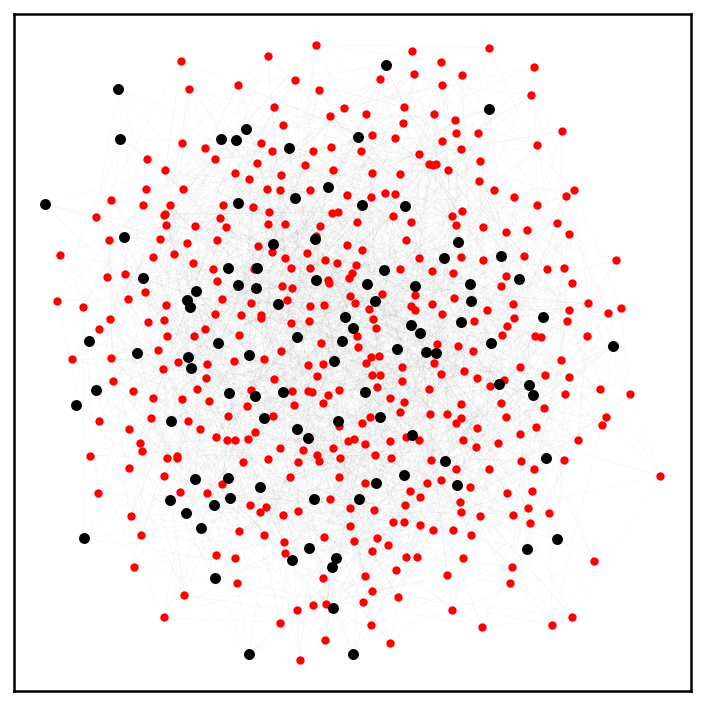

In [19]:
plt.figure(figsize=(5, 5))

# draw all
nx.draw_networkx_nodes(original_ws, 
                       pos=pos_dict,
                       node_color='r',
                       node_size=10)

nx.draw_networkx_edges(original_ws,
                       pos=pos_dict,
                       width=0.05,
                       alpha=0.2)

# draw the one LEFT after vaccination
nx.draw_networkx_nodes(vacc_graph, 
                       pos=pos_dict,
                       node_color='k',
                       node_size=20)


plt.tight_layout()

plt.savefig('network_fig/'+ graph_name + '.pdf')

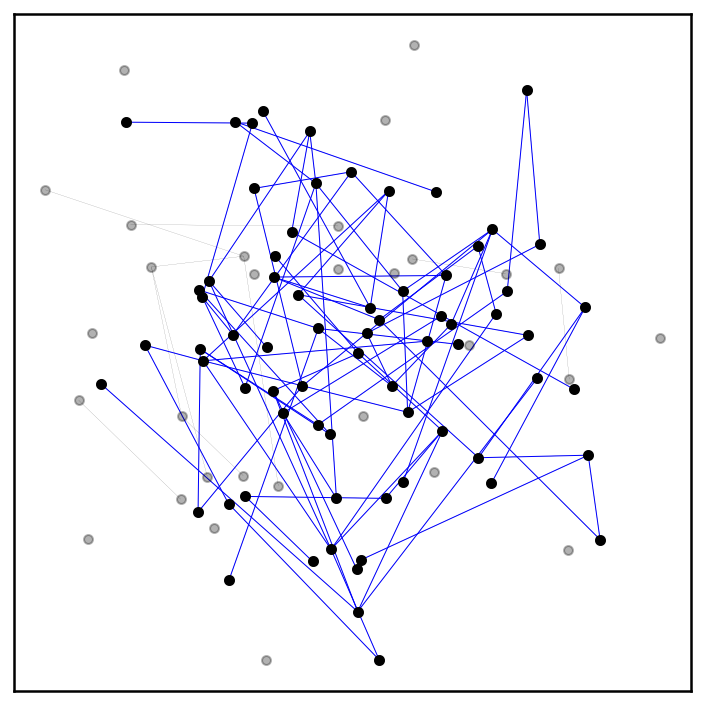

In [20]:
plt.figure(figsize=(5, 5))

# draw the one LEFT after vaccination
nx.draw_networkx_nodes(vacc_graph, 
                       pos=pos_dict, 
                       node_color='k', 
                       node_size=20,
                       alpha=0.3)

nx.draw_networkx_edges(vacc_graph, 
                       pos=pos_dict, 
                       width=0.05)

# detect GCC (giant connected component)...
nodes_gcc_vacc = max(nx.connected_components(vacc_graph), key=len)
gcc_vacc = vacc_graph.subgraph(nodes_gcc_vacc)

# ...and highlight its nodes and edges
nx.draw_networkx_edges(gcc_vacc, 
                       pos=pos_dict, 
                       width=0.5, 
                       edge_color='b')

nx.draw_networkx_nodes(gcc_vacc, 
                       pos=pos_dict, 
                       node_color='k', 
                       node_size=20)

plt.tight_layout()

plot_name = f'after_vacc_n_nodes_{n_nodes}_nnn_{nnn}_p_edge_{p_edge}_vacc_cov_{vacc_cov}'
plt.savefig('network_fig/' + plot_name + '.pdf')

In [21]:
## estimation of upper bound of epidemics size -- after vaccination
cc_sizes = [len(cc) for cc in nx.connected_components(vacc_graph)]
esti_uppb_epi = sum(np.array(cc_sizes)**2) / vacc_graph.number_of_nodes()

# extract degrees from original graph
degrees = list(dict(original_ws.degree()).values())

# segregation effect

## run simulations

In [3]:
def segregation_fun(thrd,
                    n_nodes=1000,
                    nnn=10,
                    edge_p=0.01,
                    ts_multiplier=4,
                    net_type='WS',
                    type_dist='CIRC'):
    '''
    first call the generation fun, then run segregation algo. given:
    
    * threshold for distance on social-status (for segregation algo)
    * parameters for network generation (n_nodes, numb. nea. neigh., edge prob., net_type)
    * ts_multiplier, such that: N_timesteps = N_nodes * ts_multiplier
    * dist_type to use to define distances in 'social status' -- 'CIRC' or 'EUCL'
    '''

    if type_dist == 'CIRC':
        dist_on_edge = circ_dist
    elif type_dist == 'EUCL':
        dist_on_edge = eucl_dist
    else:
        raise ValueError('WRONG dist_type')

    ## ## generate new network ## ##
    graph = generate_netw_fun(my_n=n_nodes,
                              my_k=nnn,
                              my_p=edge_p,
                              my_net_type=net_type)
    init_N_edges = graph.number_of_edges()  # store N edges for checks

    # initialize temporary moves count
    moves_n = 0

    ## initialize metrics
    #     global segre_assort_ts
    #     global modularity_ts
    #     global degree_assort_ts
    #     global av_clus_coeff_ts

    for n in range(ts_multiplier):

        # make a temp. copy to avoid conflicts, ...
        temp_edges = list(graph.edges())

        for nodes_couple in temp_edges:

            # check if distance of nodes is above threshold
            old_couple_dist = dist_on_edge(
                graph.nodes[nodes_couple[0]]['social_status'],
                graph.nodes[nodes_couple[1]]['social_status'])
            if old_couple_dist > thrd:

                # pick node from the old edge ...
                node_to_rewire = random.choice(
                    [nodes_couple[0], nodes_couple[1]])

                # pick new node outside its neighrhood!!! @ random

                new_neigh = random.choice(
                    list(graph.nodes() - graph.neighbors(node_to_rewire) -
                         {node_to_rewire}))

                # check if new neigh is close enough
                new_couple_dist = dist_on_edge(
                    graph.nodes[node_to_rewire]['social_status'],
                    graph.nodes[new_neigh]['social_status'])

                ## the decision might either be based on local status or on general threshold
                #                 if new_couple_dist < old_couple_dist:
                if new_couple_dist < thrd:

                    #  create a new edge and remove the previouS one!
                    graph.add_edge(node_to_rewire, new_neigh)
                    graph.remove_edge(nodes_couple[0], nodes_couple[1])

                    moves_n += 1

    if graph.number_of_edges() != init_N_edges:
        print('new N edges:', graph.number_of_edges(), 'init_N_edges:',
              init_N_edges)
        raise ValueError('N edges has changed')


#         segre_assort_ts.append(att_assortativity(graph))
#         modularity_ts.append(modularity(graph,greedy_modularity_communities(graph)))
#         degree_assort_ts.append(nx.degree_pearson_correlation_coefficient(graph))
#         av_clus_coeff_ts.append(nx.average_clustering(graph))

    return graph, moves_n

In [4]:
# function for network metrics
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity

In [14]:
def fun_to_par(tld):
    
    ## store propertis across different tlds
    netw_prop = []

    start_time = timeit.default_timer()
    
    for i in range(n_runs):

        ## run segregation for given thre.
        current_graph, n_moves = segregation_fun(tld, n_nodes=nodes_n, nnn=n_nn, edge_p=p_edge,
                                                 net_type=type_net, type_dist=dist_type)
    

        ### ### ### ### ### ### ### ### ### ### ### 
        ### ### compute metrics ### ### 

        ## extract N conn. compo. and largest conn. compo.
#         n_conn_comp = nx.number_connected_components(current_graph)        
        nodes_largest_cc = max(nx.connected_components(current_graph), key=len)
        largest_cc = current_graph.subgraph(nodes_largest_cc)
#         largest_cc_fraction = largest_cc.number_of_nodes() / current_graph.number_of_nodes()

        ## topological metrics - on largest cc!
        ss_ass = att_assortativity(largest_cc)
        modul = modularity(largest_cc,greedy_modularity_communities(largest_cc))
        
        # compute as well mean degree
#         mean_degree = np.mean([d[1] for d in largest_cc.degree()])
        
        
        netw_prop.append({'threshold': tld, 'metric': 'n_moves', 'value': n_moves})        
        netw_prop.append({'threshold': tld, 'metric': 'ss_assort', 'value': ss_ass})        
        netw_prop.append({'threshold': tld, 'metric': 'modul', 'value': modul})        
    
#         netw_prop.append({'threshold': tld, 'metric': 'largest_cc_fraction', 'value': largest_cc_fraction})
#         netw_prop.append({'threshold': tld, 'metric': 'n_conn_comp', 'value': n_conn_comp})        
#         netw_prop.append({'threshold': tld, 'metric': 'mean_degree', 'value': mean_degree})                
        ### ### ### ### ### ### ### ### ### ### ### ### 
    
        
        ## run vaccination for given coverage
#         for vacc_cov in np.linspace(0.5,0.9,5):
        for vacc_cov in np.linspace(0.5,0.9,11):
            
            
            vacc_graph = vacc_fun(current_graph, coverage=vacc_cov)

            ## estimation of upper bound of epidemics size
            cc_sizes = [len(cc) for cc in nx.connected_components(vacc_graph)]
            esti_uppb_epi = sum(np.array(cc_sizes)**2) / vacc_graph.number_of_nodes()
            netw_prop.append({'threshold': tld, 'vacc_cov': vacc_cov ,'metric': 'esti_uppb_epi', 'value': esti_uppb_epi})

    print('done with threshold:',tld, 'in sec:',timeit.default_timer() - start_time)
    return netw_prop  

run the simulations in parallel

In [6]:
# parameters for network construction
type_net = 'WS' # 'ER'
nodes_n = 1000
p_edge = 0.01
n_nn = 10

# multiplier for total N. runs of segregation algo.
# multip_segr_runs = 30
dist_type = 'CIRC' # 'EUCL'

# parameters for vaccination
n_runs = 10
vacc_cov = 0.6

ISSUES WITH RUNNING THIS CELL

In [19]:
# loop over threshold
thres_list = np.logspace(-3,np.log10(0.5),10)    # np.linspace(0.1, 0.3, 10) # np.linspace(0.01, 0.5, 10) 


if pool:
    pool.close()  # for testing / debug
    
pool = multiprocessing.Pool(multiprocessing.cpu_count())

%time netw_prop = pool.map(fun_to_par, thres_list)

pool.close()
pool.join()

done with threshold: 0.12566053148961803 in sec: 95.01187322700002
done with threshold: 0.06299605249474363 in sec: 98.12931252000004
done with threshold: 0.0315811383485066 in sec: 101.31771651399998
done with threshold: 0.001 in sec: 101.85665518599995
done with threshold: 0.0019947365987750282 in sec: 102.10865146100002
done with threshold: 0.003978974098492568 in sec: 102.23019960799996
done with threshold: 0.015832234876474737 in sec: 102.305015513
done with threshold: 0.007937005259840991 in sec: 102.88284750199995
done with threshold: 0.5 in sec: 22.55686752500003
done with threshold: 0.250659661183863 in sec: 35.437820402
CPU times: user 61.5 ms, sys: 46.5 ms, total: 108 ms
Wall time: 2min 10s


 prepare dataframe for plotting 

In [23]:
# need to first flatten the list
netw_prop = [i for item in netw_prop for i in item]

netw_prop =  pd.DataFrame(netw_prop)

netw_prop.to_csv(f'sim_plots/edges_segregation/sim_data_for_type_net_{type_net}_dist_type_{dist_type}_nodes_n_{nodes_n}_p_edge_{p_edge}_n_nn_{n_nn}_n_runs_{n_runs}.csv')

print(netw_prop.metric.value_counts())
print(netw_prop.isnull().sum())
print(netw_prop.shape)
netw_prop.head()



esti_uppb_epi    1100
modul             100
n_moves           100
ss_assort         100
Name: metric, dtype: int64
threshold      0
metric         0
value          0
vacc_cov     300
dtype: int64
(1400, 4)


,threshold,metric,value,vacc_cov
0,0.001,n_moves,53.000000,NaN
1,0.001,ss_assort,0.011706,NaN
2,0.001,modul,0.680016,NaN
3,0.001,esti_uppb_epi,463.164000,0.50
4,0.001,esti_uppb_epi,267.630435,0.54


## plot network metrics

reload simulations data

In [44]:
netw_prop = pd.read_csv('sim_plots/edges_segregation/sim_data_for_type_net_WS_dist_type_CIRC_nodes_n_1000_p_edge_0.01_n_nn_10_n_runs_10.csv',index_col=0)

# we round as there are some rounding problem, reflected then in the legend of the different plots
netw_prop = netw_prop.round(3)

print(netw_prop.dtypes)
print('df shape:',netw_prop.shape)
print('n. of unique threshold:',netw_prop.threshold.nunique())
print('n. of unique metric:',netw_prop.metric.nunique())

netw_prop.head()

threshold    float64
metric        object
value        float64
vacc_cov     float64
dtype: object
df shape: (800, 4)
n. of unique threshold: 10
n. of unique metric: 4


,threshold,metric,value,vacc_cov
0,0.001,n_moves,41.000,NaN
1,0.001,ss_assort,0.040,NaN
2,0.001,modul,0.676,NaN
3,0.001,esti_uppb_epi,451.564,0.5
4,0.001,esti_uppb_epi,192.540,0.6


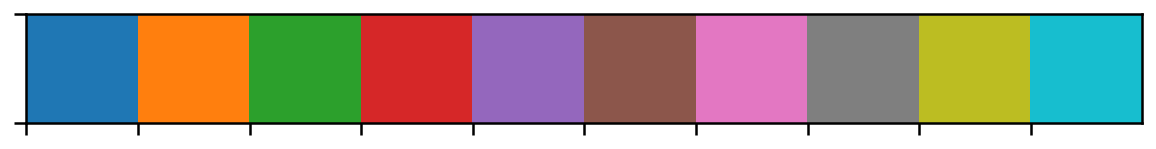

In [34]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

other network metrics

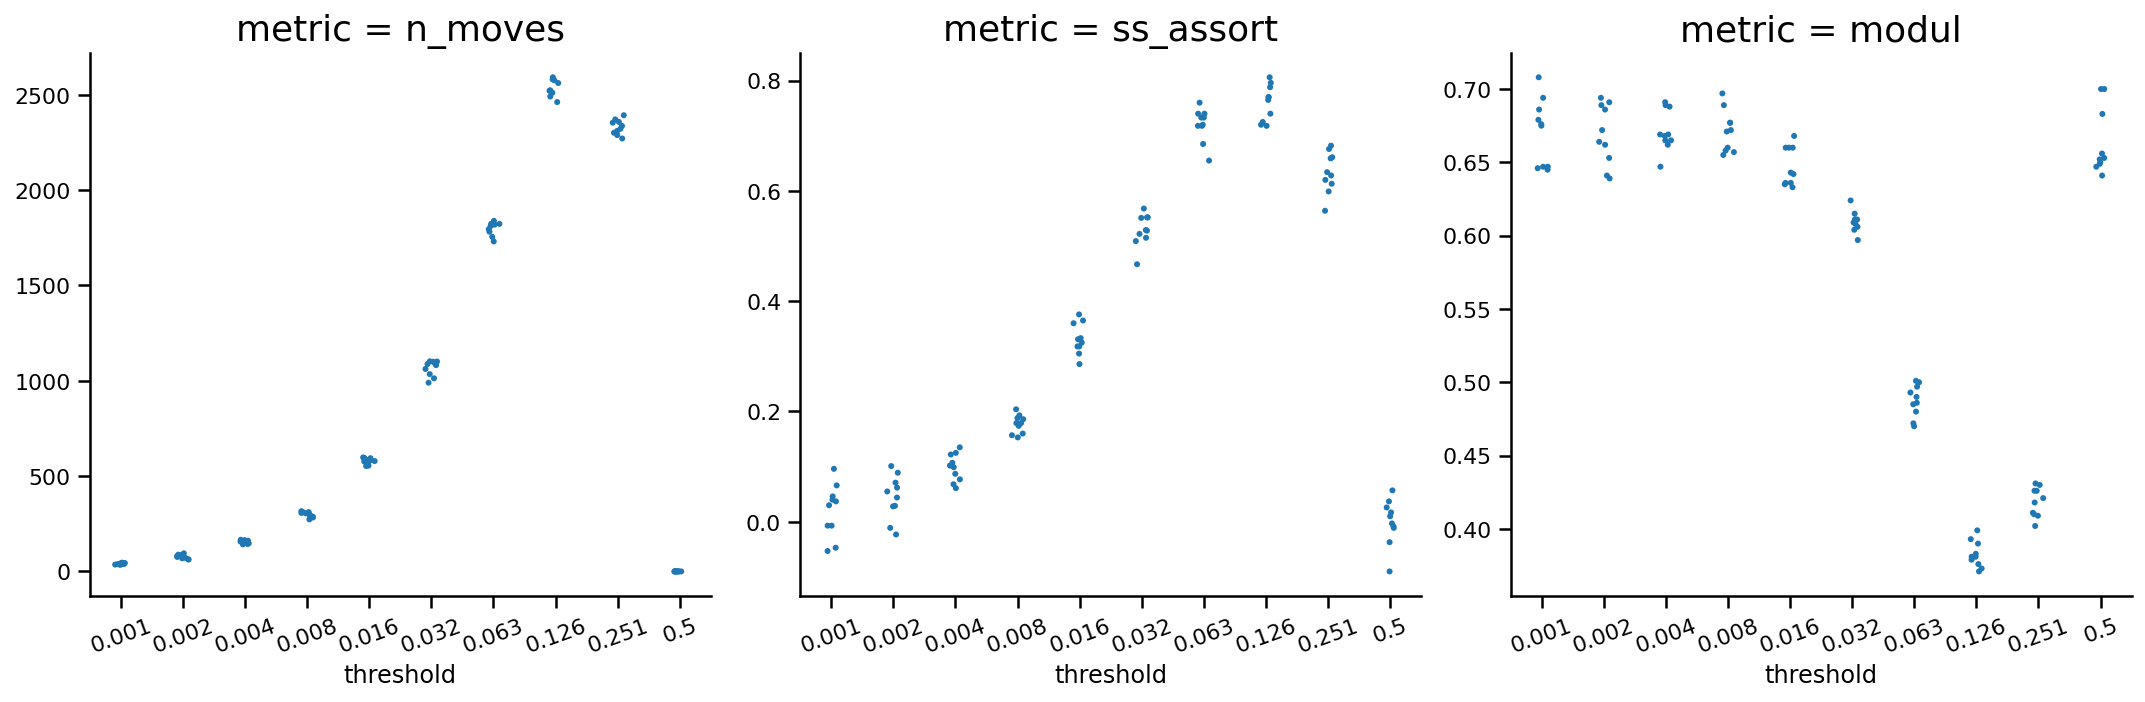

In [49]:
my_p = sns.catplot(data=netw_prop[netw_prop.metric!='esti_uppb_epi'],
                   x='threshold',col='metric',y='value',
                   sharey=False,col_wrap=3,
                   color=current_palette[0],s=3)

my_p.set_titles(size=18)
my_p.set_ylabels('')
my_p.set_xticklabels([np.round(t,3) for t in netw_prop.threshold.unique()],rotation=20)

plt.tight_layout()

plt.savefig('./sim_plots/edges_segregation/segre_PARS_type_net_{}_dist_type_{}_nodes_n_{}_p_edge_{}_n_nn_{}_n_runs_{}.pdf'.\
            format(type_net,dist_type,nodes_n,p_edge,n_nn,n_runs))
plt.show();

average upper bound to outbreak size

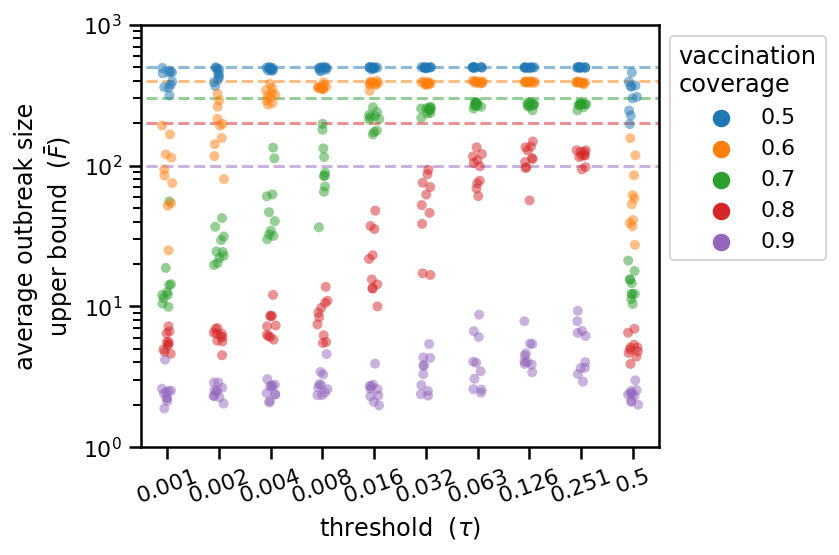

In [68]:
# plt.figure(figsize=(5,5))
# upper_b_plot = sns.pointplot(data=netw_prop[netw_prop.metric=='esti_uppb_epi'],
upper_b_plot = sns.stripplot(
    data=netw_prop[netw_prop.metric == 'esti_uppb_epi'],
    x='threshold',
    y='value',
    hue='vacc_cov',
    alpha=0.5)  # ,size=3,ci='sd',legend='full'

upper_b_plot.set_xticklabels(
    [np.round(t, 3) for t in netw_prop.threshold.unique()], rotation=20)

### ### ### add h-lines for theor. max for fully connected graph ### ### 
left_N_fun = lambda x:nodes_n*(1-x)
i = 0
for vacc in netw_prop.vacc_cov.unique()[1:]:
    upper_b_plot.axhline(left_N_fun(vacc),xmin=0.01,xmax=1,color=current_palette[i],alpha=0.5,linestyle='dashed')
    i +=1
### ### ### ### ### ### ### ### ### ### ### ### ### ### ### 

upper_b_plot.legend(bbox_to_anchor=(1, 1), title='vaccination\ncoverage')
upper_b_plot.set_xlabel(r'threshold  ($\tau$)')
upper_b_plot.set_ylabel(
    'average outbreak size\nupper bound' +
    r'  ($\bar{F}$)')  # upper_b_plot.set_ylabel(r'$\bar{F}$')

upper_b_plot.set_ylim([10**0, 10**3])
upper_b_plot.set_yscale('log')
plt.tight_layout()

plt.savefig('./sim_plots/edges_segregation/upper_b_ACROSS_vacc_cov_PARS_type_net_{}_dist_type_{}_nodes_n_{}_p_edge_{}_n_nn_{}_n_runs_{}.pdf'.\
            format(type_net,dist_type,nodes_n,p_edge,n_nn,n_runs))

plt.show();

## vaccination-dependency of segregation effect

mind that this plot is obtained from re-running the simulations (`fun_to_par`) with __11__ values of vaccination coverage -- basically, you have to un-comment the line 

```
         for vacc_cov in np.linspace(0.5,0.9,11):
```

in the definition of `segregation_fun`

compute mean and std, per each threshold ( $\tau$ )

In [24]:
# compute mean
grouped_df = netw_prop[netw_prop.metric == 'esti_uppb_epi'].groupby(['threshold', 'vacc_cov']).mean()
grouped_df.reset_index(inplace=True)
grouped_df.rename(columns={'value':'F_mean'},inplace=True)

# compute std
grouped_std = netw_prop[netw_prop.metric == 'esti_uppb_epi'].groupby(['threshold', 'vacc_cov']).std()
grouped_std.reset_index(inplace=True)
grouped_std.rename(columns={'value':'F_std'},inplace=True)

# merge dfs
grouped_stats = grouped_df.merge(grouped_std,on=['threshold','vacc_cov'])
print(grouped_stats.shape)

del grouped_df,grouped_std
gc.collect();
grouped_stats.head()

(110, 4)


,threshold,vacc_cov,F_mean,F_std
0,0.001,0.50,447.079600,67.023028
1,0.001,0.54,296.312609,72.987432
2,0.001,0.58,142.894286,49.756842
3,0.001,0.62,75.860526,41.575996
4,0.001,0.66,36.285882,19.821735


error bars version of previous plot 

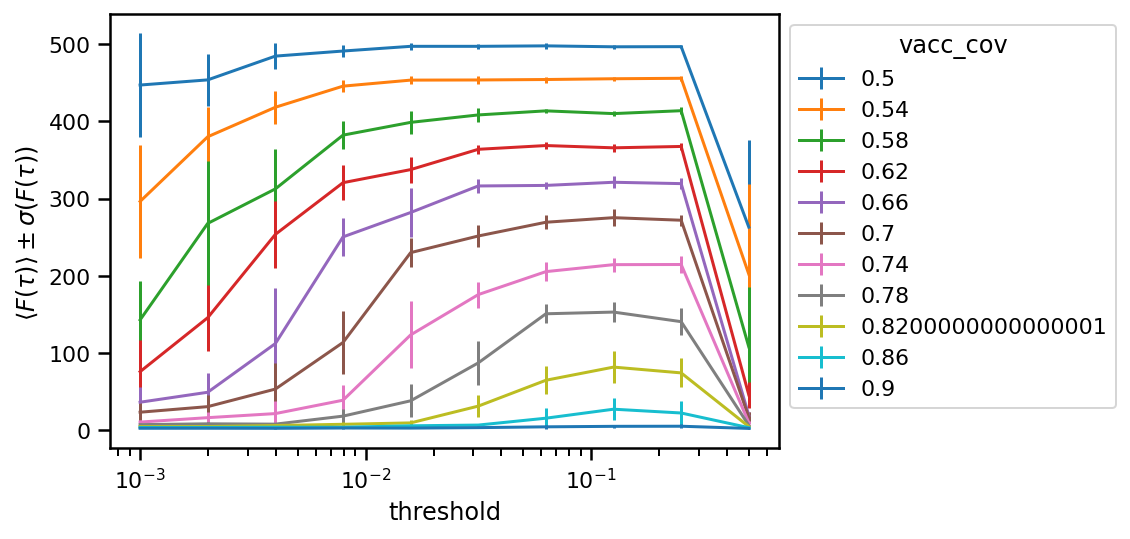

In [26]:
for my_vax in grouped_stats.vacc_cov.unique():

    plt.errorbar(data=grouped_stats[grouped_stats.vacc_cov == my_vax],
                 x='threshold',
                 y='F_mean',
                 label='vacc_cov',
                 yerr='F_std')

plt.xscale('log')

plt.legend(labels=grouped_stats.vacc_cov.unique(),
           title='vacc_cov',
           bbox_to_anchor=(1, 1))
plt.xlabel('threshold')
plt.ylabel(r'$\langle F(\tau) \rangle \pm \sigma(F(\tau))$ ');

compute $F( \tau )$ ratios and error estimate

In [27]:
f_ratios = {}
ratios_err = {}

for my_vax in grouped_stats.vacc_cov.unique():
    
    min_filter = (grouped_stats.vacc_cov == my_vax) & (grouped_stats.threshold == grouped_stats.threshold.min())
    max_filter = grouped_stats[grouped_stats.vacc_cov == my_vax].F_mean.idxmax()
    
#     f_ratios[my_vax] = grouped_stats[grouped_stats.vacc_cov == my_vax].F_mean.max() / \
#                         grouped_stats[min_filter].F_mean.values[0]

    f_ratios[my_vax] = grouped_stats.iloc[max_filter].F_mean / grouped_stats[min_filter].F_mean.values[0]
    
    ratios_err[my_vax] = f_ratios[my_vax] * ( grouped_stats.iloc[max_filter].F_std / grouped_stats.iloc[max_filter].F_mean + 
                                             grouped_stats[min_filter].F_std.values[0] / grouped_stats[min_filter].F_mean.values[0])

f_ratio_df = pd.DataFrame([f_ratios,ratios_err]).transpose()
f_ratio_df.columns = ['ratio','error']
del f_ratios, ratios_err
f_ratio_df

,ratio,error
0.50,1.113478,0.175142
0.54,1.538308,0.390071
0.58,2.896137,1.039365
0.62,4.860423,2.718463
0.66,8.850663,5.043722
0.70,11.790903,7.904278
0.74,20.283783,6.258884
0.78,21.125879,5.938153
0.82,17.198645,7.937342
0.86,7.645950,5.237488


final plot

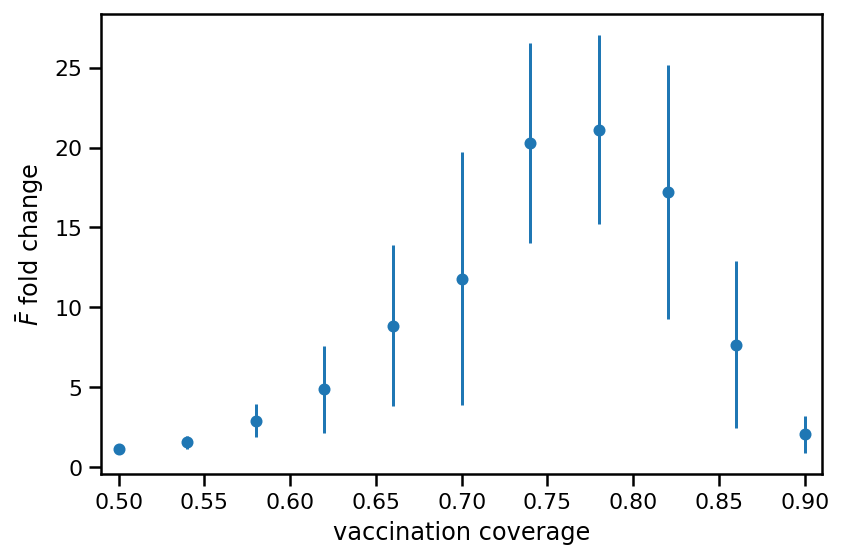

In [28]:
plt.errorbar(x=f_ratio_df.index,
             y=f_ratio_df.ratio, yerr=f_ratio_df.error,
             linestyle='', marker='.', ms=10)

plt.xlim([0.49, 0.91])

plt.xlabel('vaccination coverage')
# plt.ylabel(r'$max_{\tau}(\langle\bar{F}\rangle(\tau)) \;  / \; \langle\bar{F}\rangle(\tau=min(\tau))$')
plt.ylabel(r'$\bar{F}$ fold change')

plt.tight_layout()
plt.savefig('./sim_plots/edges_segregation/F_ratio_ACROSS_vacc_cov_PARS_type_net_{}_dist_type_{}_nodes_n_{}_p_edge_{}_n_nn_{}_n_runs_{}.pdf'.\
            format(type_net,dist_type,nodes_n,p_edge,n_nn,n_runs))